In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import os
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize

<br>
<left><b><font size=4>Section 1 – Data exploration and pre-processing<b><left>

Dataset of all the SSH sessions

In [2]:
if not os.path.isfile("ssh_attacks_decoded_splitted.parquet"):
    raise Exception("You should run the preprocessing file")
df = pd.read_parquet("ssh_attacks_decoded_splitted.parquet")

**1. When are the attacks performed? Analyze the temporal series.**

In [3]:
# Creating a new DataFrame containing only attack instances
# Excluding sessions labeled as "Harmless" with a single label
df_attacks = df.loc[~df["Set_Fingerprint"].apply(lambda session : "Harmless" in session and len(session) == 1)]
attacks_per_day = df_attacks['first_timestamp'].dt.date.value_counts().sort_index().to_frame("Number_of_attacks_per_day")

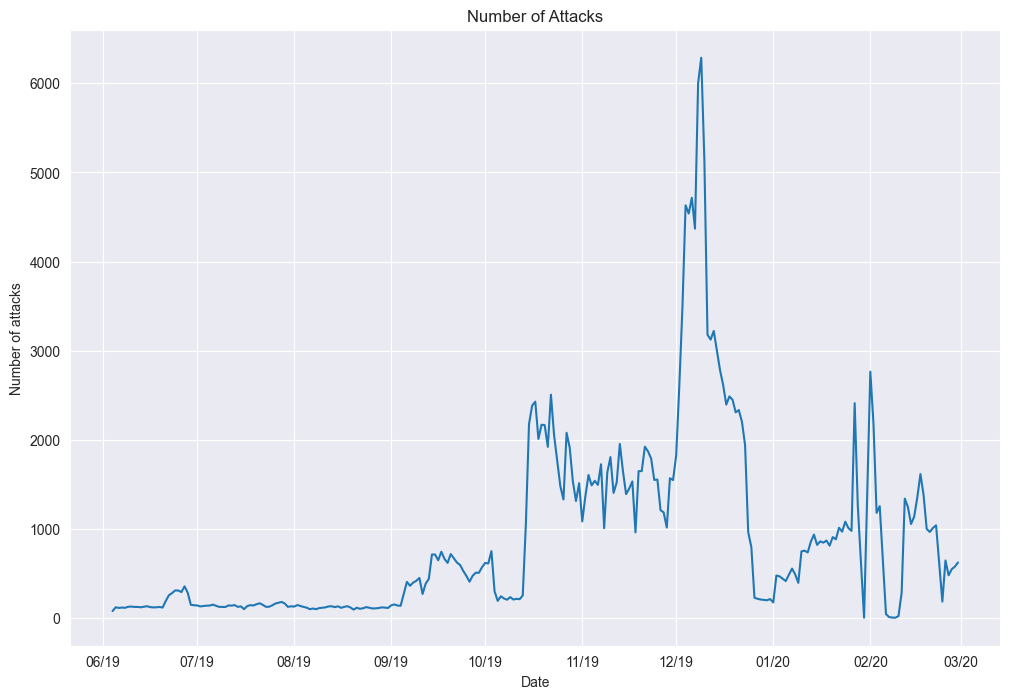

In [4]:
plt.figure(figsize=(12,8))
sns.set_style("darkgrid")

sns.lineplot(
    data = attacks_per_day,
    linestyle='-',
    color= 'blue',
    legend=False
)

plt.title('Number of Attacks')
plt.xlabel("Date")
plt.ylabel("Number of attacks")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.show()

In [5]:
attacks_per_year = df_attacks.groupby(df['first_timestamp'].dt.year).size().to_frame("Number_attacks").reset_index()
attacks_per_year.rename(columns={"first_timestamp": "Year"}, inplace=True)

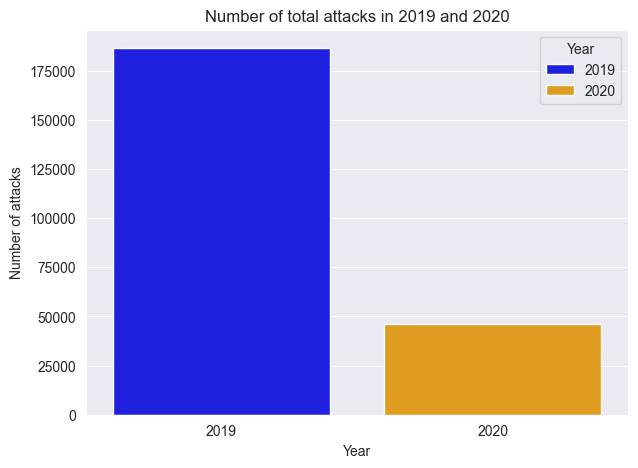

In [6]:
plt.figure(figsize=(7,5))
sns.barplot(
    data = attacks_per_year,
    x = "Year",
    y = "Number_attacks",
    hue= "Year",
    palette = ['blue','orange']
)

plt.ylabel("Number of attacks")
plt.title("Number of total attacks in 2019 and 2020")
plt.show()

In [7]:
df_attacks_2019 = df_attacks.loc[df_attacks["first_timestamp"].dt.year == 2019]
df_attacks_2019_month = df_attacks_2019.groupby(df_attacks_2019["first_timestamp"].dt.month).size().to_frame("Number_attacks_2019_month").reset_index()

df_attacks_2020 = df_attacks.loc[df_attacks["first_timestamp"].dt.year == 2020]
df_attacks_2020_month = df_attacks_2020.groupby(df_attacks_2020["first_timestamp"].dt.month).size().to_frame("Number_attacks_2020_month").reset_index()

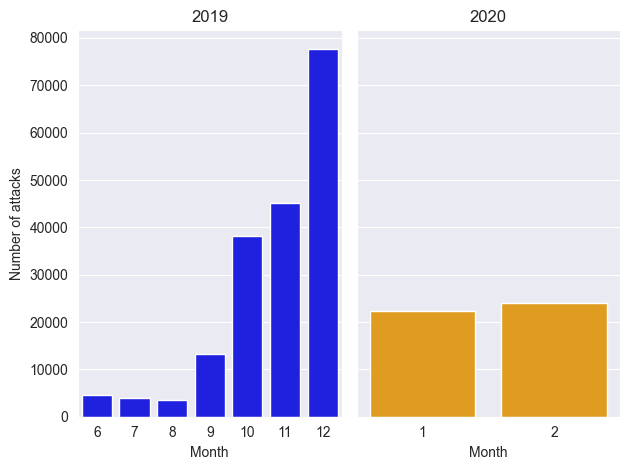

In [8]:
sns.set_style("darkgrid")

fig, axes = plt.subplots(1,2 ,sharey=True)
plt.subplot(1,2,1)
sns.barplot(
    data = df_attacks_2019_month,
    x = "first_timestamp",
    y = "Number_attacks_2019_month",
    ax=axes[0],
    color = 'blue'  
)
plt.title("2019")
plt.xlabel("Month")
plt.ylabel("Number of attacks")

plt.subplot(1,2,2)
sns.barplot(
    data = df_attacks_2020_month,
    x = "first_timestamp",
    y = "Number_attacks_2020_month",
    ax=axes[1],
    color = 'orange'
)
plt.title("2020")
plt.xlabel("Month")
plt.ylabel("Number of attacks")

plt.tight_layout()
plt.show()

**1.2. Extract features from the attack sessions. How does the empirical distribution of the number of
characters in each session look like? How is the distribution of the number of word per session?**

In [9]:
# Calculate the number of characters and words in each session

number_words = df['full_session'].apply(lambda session: len(session))
number_characters = df['full_session'].apply(lambda session: sum([len(word) for word in session]))

data = {"number_characters": number_characters, "number_words": number_words}
df_number_characters_words = pd.DataFrame(data = data)

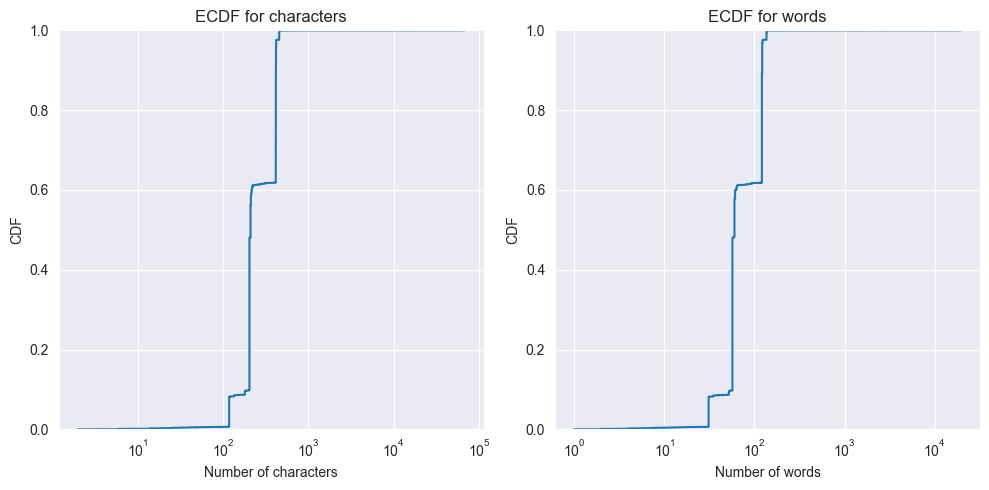

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.ecdfplot(
    data = df_number_characters_words['number_characters'],
    log_scale=True
)
plt.title("ECDF for characters")
plt.xlabel("Number of characters")
plt.ylabel("CDF")

plt.subplot(1,2,2)
sns.ecdfplot(
    data = df_number_characters_words['number_words'],
    log_scale=True
)
plt.title("ECDF for words")
plt.xlabel("Number of words")
plt.ylabel("CDF")

plt.tight_layout()
plt.show()

**1.3. What are the most common words in the sessions?**

In [15]:
all_words = df["full_session"].explode()

In [16]:
df_most_common_words = all_words.value_counts().head(10)
most_common_word = df_most_common_words.idxmax()
frequency = df_most_common_words.max()
word_freq=df_most_common_words.to_dict()
print(f"The most  common word is: {most_common_word}")

The most  common word is: tmp


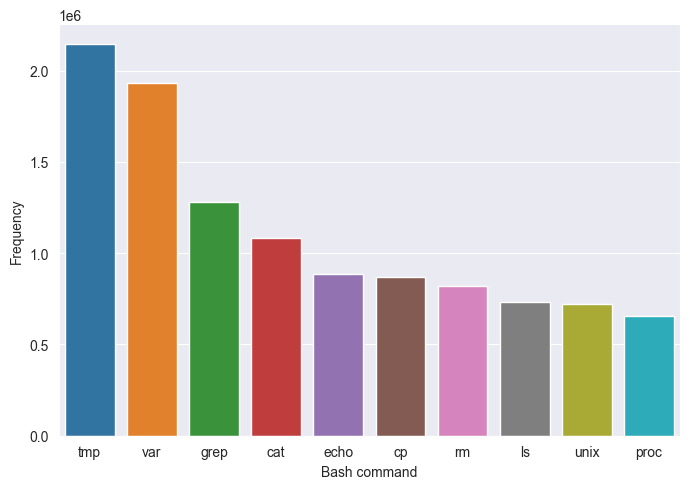

In [13]:
plt.figure(figsize=(7,5))
sns.barplot(
    data = pd.DataFrame([word_freq]),
)
plt.xlabel("Bash command")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

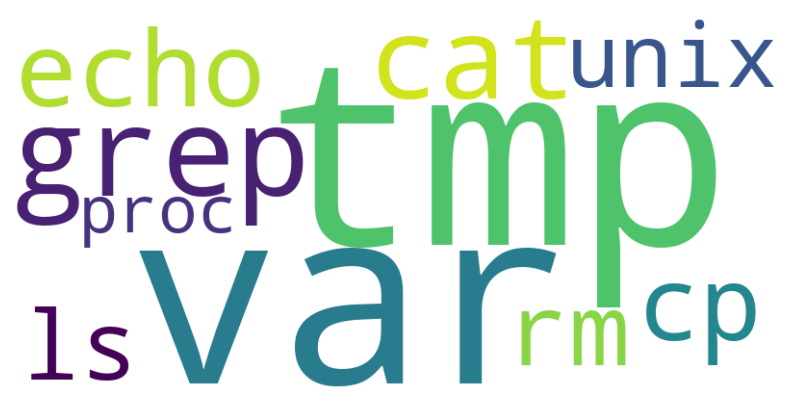

In [14]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**1.4. How are the intents distributed? How many intents per session do you observe? What are the most common intents? How are the intents distributed in time?**

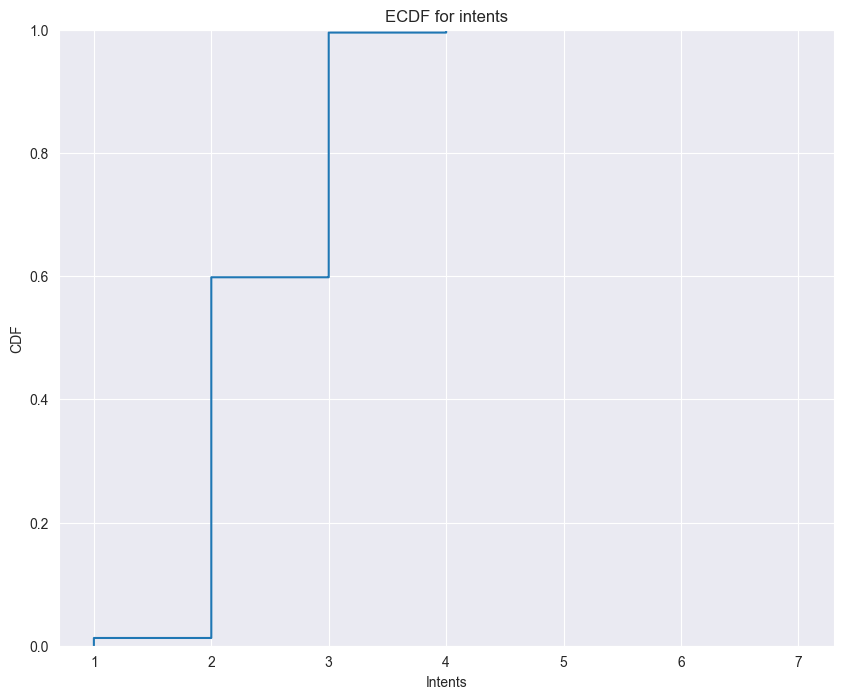

In [19]:
df_intents = df[["session_id", "first_timestamp", "Set_Fingerprint"]]

# Expanding the 'Set_Fingerprint' column to individual intents and sessions
df_intents_exploted = df_intents.explode('Set_Fingerprint')
intents_df_grouped = df_intents_exploted.groupby("session_id").size().to_frame("Number_of_intents")

plt.figure(figsize=(10,8))
sns.ecdfplot(
    data = intents_df_grouped,
    legend=False
)
plt.title("ECDF for intents")
plt.xlabel("Intents")
plt.ylabel("CDF")
plt.show()

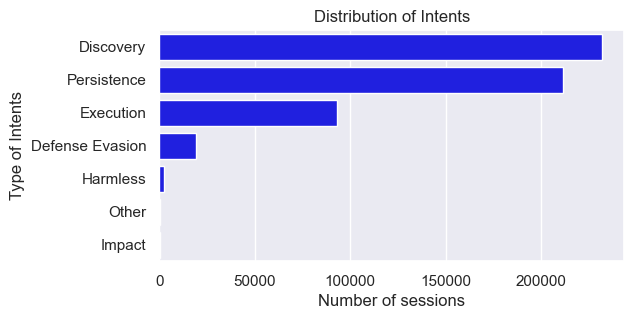

In [20]:
intents = df_intents_exploted.groupby('Set_Fingerprint').size().sort_values(ascending=False).to_frame("Number_of_sessions")
sns.set_theme(style="darkgrid")
plt.figure(figsize=(6,3))
sns.barplot(intents, x="Number_of_sessions", y=intents.index, color="blue", hue_order=intents.index)
plt.title('Distribution of Intents')
plt.xlabel('Number of sessions')
plt.ylabel('Type of Intents')

plt.show()

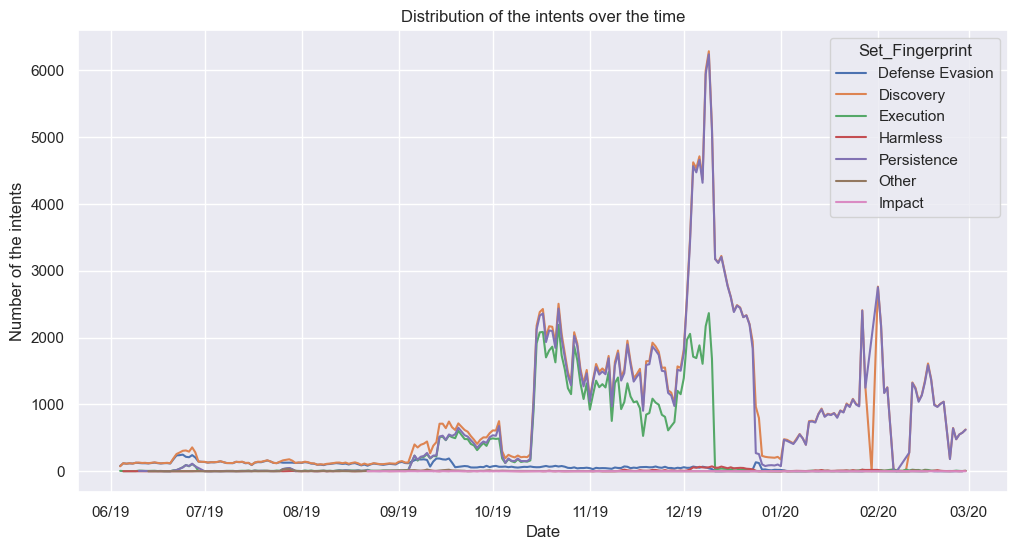

In [21]:
df_intents_distribution = df_intents_exploted.groupby([pd.Grouper(key='first_timestamp', freq='D'), 'Set_Fingerprint']).size().to_frame("Number_of_intents").reset_index()
df_intents_distribution
plt.figure(figsize=(12, 6))
sns.lineplot(
    data = df_intents_distribution,
    x = "first_timestamp",
    y = "Number_of_intents",
    hue="Set_Fingerprint",
    legend=True
)
plt.title("Distribution of the intents over the time")
plt.xlabel("Date")
plt.ylabel("Number of the intents")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))

plt.show()

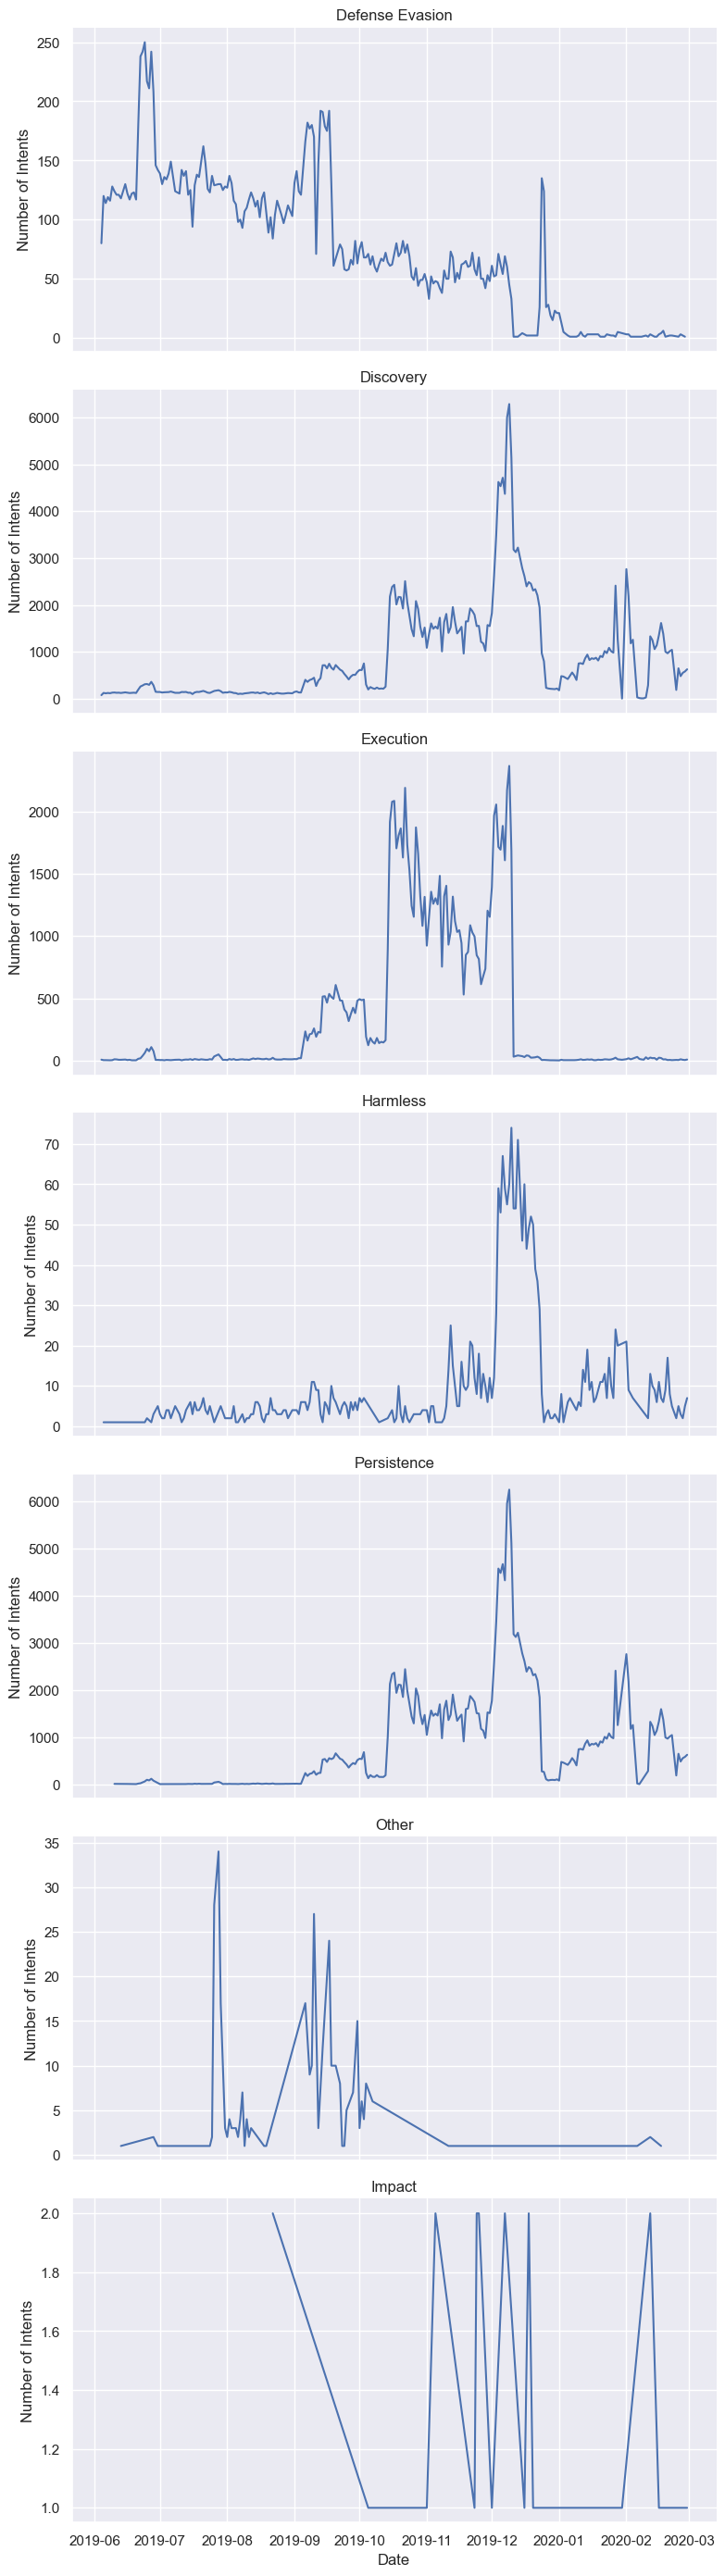

In [23]:
grid = sns.FacetGrid(df_intents_distribution, col="Set_Fingerprint", col_wrap=1, height=4, sharey=False, aspect=2)

grid.map(sns.lineplot, "first_timestamp", "Number_of_intents")

grid.set_axis_labels("Date", "Number of Intents")
grid.set_titles(col_template="{col_name}")

plt.show()

**1.5. How can text represented numerically? Try to convert the text into numerical representations
(vectors) through Bag of Words (BoW)**

In [24]:
if not os.path.isfile("df_features_bow.parquet"):
    count_vectorizer = CountVectorizer(min_df = 0.05)
    bow = count_vectorizer.fit_transform(df["full_session"].apply(lambda x : " ".join(x)))
    df_bow = pd.DataFrame(bow.toarray(), index=df.index, columns = list(count_vectorizer.vocabulary_.keys()))
    for feature in df_bow.columns:
        df_bow[feature] = normalize(df_bow[feature].values.reshape(-1,1), norm="l2", axis=0)
    df_bow = pd.concat([df, df_bow], axis=1)
    df_features_bow = df_bow.drop(columns=["session_id", "full_session", "first_timestamp"])
    # move Set Fingerprint column as last column of the dataframe
    # df_features_bow.insert(len(df_features_bow.columns)-1, "Set_Fingerprint", df_features_bow.pop("Set_Fingerprint"))
    df_features_bow.to_parquet("df_features_bow.parquet")
else:
    df_features_bow = pd.read_parquet("df_features_bow.parquet")

In [25]:
%run "train_test_split_sampled.ipynb" 
if not os.path.isfile("df_features_bow_sampled.parquet"):
    df_features_bow_sampled = sampling(df_features_bow)
    df_features_bow_sampled.to_parquet("df_features_bow_sampled.parquet")

**1.6. Associate each word in each attack session with its TF-IDF value (Term Frequency-Inverse Document Frequency)**

In [26]:
if not os.path.isfile("df_features_tfidf.parquet"):
    tfidf_vectorizer = TfidfVectorizer(min_df = 0.05)
    tfid = tfidf_vectorizer.fit_transform(df["full_session"].apply(lambda x : " ".join(x)))
    df_tfidf = pd.DataFrame(tfid.toarray(), index=df.index, columns = list(tfidf_vectorizer.vocabulary_.keys()))
    df_tfidf = pd.concat([df, df_tfidf], axis=1)
    df_features_tfidf = df_tfidf.drop(columns=["session_id", "full_session", "first_timestamp"])
    # move Set Fingerprint column as last column of the dataframe
    # df_features_tfidf.insert(len(df_features_tfidf.columns)-1, "Set_Fingerprint", df_features_tfidf.pop("Set_Fingerprint"))
    df_features_tfidf.to_parquet("df_features_tfidf.parquet")
else:
    df_features_tfidf = pd.read_parquet("df_features_tfidf.parquet")

In [27]:
%run "train_test_split_sampled.ipynb" 
if not os.path.isfile("df_features_tfidf_sampled.parquet"):
    df_features_tfidf_sampled = sampling(df_features_tfidf)
    df_features_tfidf_sampled.to_parquet("df_features_tfidf_sampled.parquet")